# SkillFactory
## Введение в ML, введение в sklearn

В этом задании мы с вами рассмотрим данные с конкурса [Задача предсказания отклика клиентов ОТП Банка](http://www.machinelearning.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D1%82%D0%BA%D0%BB%D0%B8%D0%BA%D0%B0_%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2_%D0%9E%D0%A2%D0%9F_%D0%91%D0%B0%D0%BD%D0%BA%D0%B0_%28%D0%BA%D0%BE%D0%BD%D0%BA%D1%83%D1%80%D1%81%29)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

### Грузим данные

Считаем описание данных

In [2]:

df_descr = pd.read_csv('data/otp_description.csv', sep='\t', encoding='utf8')

In [3]:
#df_descr

Считаем обучающую выборки и тестовую (которую мы как бы не видим)

In [4]:
df_train = pd.read_csv('data/otp_train.csv', sep='\t', encoding='utf8')

In [5]:
df_train.shape

(15223, 52)

In [6]:
df_test = pd.read_csv('data/otp_test.csv', sep='\t', encoding='utf8')

In [7]:
df_test.shape

(14910, 52)

In [8]:
df_train.head()

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,...,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
0,59910150,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,...,0,1,1,1,6,2,1,1580,1580,NaN
1,59910230,0,32,1,0,1,3,3,Среднее,Состою в браке,...,0,1,1,1,6,1,1,4020,4020,NaN
2,59910525,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,...,0,1,2,1,11,0,0,0,0,NaN
3,59910803,0,39,1,0,1,1,1,Высшее,Состою в браке,...,1,1,1,1,6,3,1,"1589,92333333333",1590,NaN
4,59911781,0,30,1,0,0,0,0,Среднее,Состою в браке,...,0,1,2,1,16,2,1,"1152,15",2230,NaN


## Объединим две выборки

Так как пока мы пока не умеем работать sklearn  Pipeline, то для того, чтобы после предобработки столбцы в двух выборках находились на своих местах.

Для того, чтобы в дальнейшем отделить их введем новый столбец "sample"

In [9]:
df_train.loc[:, 'sample'] = 'train'
df_test.loc[:, 'sample'] = 'test'

In [10]:
df = df_test.append(df_train).reset_index(drop=True)

In [11]:
df.shape

(30133, 53)

### Чуть-чуть посмотрим на данные

Посмотрим типы данных и их заполняемость

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30133 entries, 0 to 30132
Data columns (total 53 columns):
AGREEMENT_RK                  30133 non-null int64
TARGET                        30133 non-null int64
AGE                           30133 non-null int64
SOCSTATUS_WORK_FL             30133 non-null int64
SOCSTATUS_PENS_FL             30133 non-null int64
GENDER                        30133 non-null int64
CHILD_TOTAL                   30133 non-null int64
DEPENDANTS                    30133 non-null int64
EDUCATION                     30133 non-null object
MARITAL_STATUS                30133 non-null object
GEN_INDUSTRY                  27420 non-null object
GEN_TITLE                     27420 non-null object
ORG_TP_STATE                  27420 non-null object
ORG_TP_FCAPITAL               27425 non-null object
JOB_DIR                       27420 non-null object
FAMILY_INCOME                 30133 non-null object
PERSONAL_INCOME               30133 non-null object
REG_ADDRESS_PRO

Видим, что часть данных - object, скорее всего стоки.


Давайте выведем эти значения для каждого столбца

In [13]:
for i in df_train.columns: # перебираем все столбцы
    if str(df_train[i].dtype) == 'object': # если тип столбца - object
        print('='*10)
        print(i) # выводим название столбца
        print(set(df_train[i])) # выводим все его значения (но делаем set - чтоб значения не повторялись)
        print('\n') # выводим пустую строку

EDUCATION
{'Среднее', 'Ученая степень', 'Среднее специальное', 'Неполное среднее', 'Неоконченное высшее', 'Два и более высших образования', 'Высшее'}


MARITAL_STATUS
{'Не состоял в браке', 'Разведен(а)', 'Состою в браке', 'Гражданский брак', 'Вдовец/Вдова'}


GEN_INDUSTRY
{nan, 'Развлечения/Искусство', 'Наука', 'Здравоохранение', 'ЧОП/Детективная д-ть', 'Салоны красоты и здоровья', 'Информационные технологии', 'Логистика', 'Химия/Парфюмерия/Фармацевтика', 'Банк/Финансы', 'Управляющая компания', 'Энергетика', 'Сельское хозяйство', 'Коммунальное хоз-во/Дорожные службы', 'Транспорт', 'Подбор персонала', 'Информационные услуги', 'Нефтегазовая промышленность', 'Недвижимость', 'Торговля', 'Сборочные производства', 'Маркетинг', 'Строительство', 'Ресторанный бизнес/Общественное питание', 'Страхование', 'Другие сферы', 'СМИ/Реклама/PR-агенства', 'Государственная служба', 'Юридические услуги/нотариальные услуги', 'Туризм', 'Образование', 'Металлургия/Промышленность/Машиностроение'}


GEN_TITLE


Mожно заметить что некоторые переменные, которые обозначены как строки (например PERSONAL_INCOME) на самом деле числа, но по какой-то причине были распознаны как строки

Причина же что использовалась запятая для разделения не целой части числа..

Перекодировать их можно например так:

In [14]:
#df['PERSONAL_INCOME'].map(lambda x: x.replace(',', '.')).astype('float')

Такой эффект наблюдается в столбцах `PERSONAL_INCOME`, `CREDIT`, `FST_PAYMENT`, `LOAN_AVG_DLQ_AMT`, `LOAN_MAX_DLQ_AMT`

### Теперь ваше небольшое исследование

#### Задание 1. Есть ли пропуски в данных? Что с ними сделать?

(единственного верного ответа нет - аргументируйте)

In [15]:
#В зависимости от задачи - заполнить пропуски нулями, единицами, средним или медианой. 
#Также можно удалить столбец с пропусками или удалить строки с пропусками.

#### Задание 2. Есть ли категориальные признаки? Что с ними делать?

In [16]:
#Можно закодировать категории цифрами 1,2,3, но тогда категории будут не равнозначны. 
#Или добавить новые столбцы по числу категорий, в которые записывать 1, если столбец 
#соответствует признаку, присущему данной сущности и 0, если не соответствует. 

#### Задание 3. Фунция предобработки

Напишите функцию, которая бы

* Удаляло идентификатор `AGREEMENT_RK`
* Избавлялась от проблем с '.' и ',' в стобцах PERSONAL_INCOME, CREDIT, FST_PAYMENT, LOAN_AVG_DLQ_AMT, LOAN_MAX_DLQ_AMT
* Что-то делала с пропусками
* Кодировала категориальные признаки

В результате, ваш датафрейм должен содержать только числа и не содержать пропусков!

In [17]:
def preproc_data(df_input):
    df_output = df_input.copy()
    
    df_output = df_output.drop(['AGREEMENT_RK','REG_ADDRESS_PROVINCE','FACT_ADDRESS_PROVINCE','POSTAL_ADDRESS_PROVINCE','TP_PROVINCE'], axis=1)
    
    for c in ['PERSONAL_INCOME','CREDIT','FST_PAYMENT','LOAN_AVG_DLQ_AMT','LOAN_MAX_DLQ_AMT']:
        df_output[c]=df_output[c].map(lambda x: x.replace(',', '.')).astype('float')
    
    #for c in ['GEN_INDUSTRY','GEN_TITLE','ORG_TP_STATE','ORG_TP_FCAPITAL','JOB_DIR','TP_PROVINCE']:
    #    df_output[c]=df_output[c].fillna('не задано')
    
    df_output.WORK_TIME=df_output.WORK_TIME.fillna(df_output.WORK_TIME.mean())
    df_output.PREVIOUS_CARD_NUM_UTILIZED=df_output.PREVIOUS_CARD_NUM_UTILIZED.fillna(0)
    
    df_output=pd.get_dummies(df_output, dummy_na=True,columns=['EDUCATION','MARITAL_STATUS','GEN_INDUSTRY','GEN_TITLE','ORG_TP_STATE','ORG_TP_FCAPITAL','JOB_DIR','FAMILY_INCOME','REGION_NM'])    
    return df_output

In [18]:
df_preproc = df.pipe(preproc_data)

#df_train_preproc = df_preproc.query('sample == "train"').drop(['sample'], axis=1)
#df_test_preproc = df_preproc.query('sample == "test"').drop(['sample'], axis=1)

In [19]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30133 entries, 0 to 30132
Columns: 136 entries, TARGET to REGION_NM_nan
dtypes: float64(7), int64(31), object(1), uint8(97)
memory usage: 11.8+ MB


#### Задание 4. Отделите целевую переменную и остальные признаки

Должно получится:
* 2 матрицы: X и X_test
* 2 вектора: y и y_test

In [20]:
from sklearn.cross_validation import train_test_split
y=df_preproc['TARGET']
df_preproc = df_preproc.drop(['TARGET', 'sample'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_preproc, y, test_size=0.3, random_state=42)

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Задание 5. Обучение и оценка качества разных моделей

In [21]:
#from sklearn.cross_validation import train_test_split
# test_size=0.3, random_state=42

#X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)
#y_train=df_train_preproc['TARGET']
#df_train_preproc = df_train_preproc.drop(['TARGET'], axis=1)

In [22]:
#y_test=df_test_preproc['TARGET']
#df_test_preproc = df_test_preproc.drop(['TARGET'], axis=1)

In [23]:
#df_train_preproc.info()

In [36]:
# Попробовать следующие "черные ящики": интерфейс одинаковый 
#     fit, 
#     predict, 
#     predict_proba

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score



## Your Code Here
classifiers = { 
    'dtc' : DecisionTreeClassifier(),
    'rfc' : RandomForestClassifier(),
    'lr' : LogisticRegression(),
}

predict = dict()

for key, c in classifiers.items():
    c.fit(X_train, y_train)
    predict[key] = c.predict(X_test)
    
    #print('%s \t precision' % key, precision_score(y_test, predict))
    #print('%s \t recall' % key, recall_score(y_test, predict))
    #print('%s \t accuracy' % key, accuracy_score(y_test, predict))
    #print('\n')
    

In [45]:
# Посчитать метрики стандартные
# accuracy, precision, recall
precision = dict()
recall = dict()
accuracy = dict()
for key,pr in predict.items():
    precision[key]=precision_score(y_test, pr)
    print('%s \t precision' % key, precision[key])
    recall[key]=recall_score(y_test, pr)
    print('%s \t recall' % key, recall[key])
    accuracy[key]=accuracy_score(y_test, pr)
    print('%s \t accuracy' % key, accuracy[key])
    print('\n')

dtc 	 precision 0.1718882303132938
dtc 	 recall 0.18640955004591367
dtc 	 accuracy 0.7938053097345132


rfc 	 precision 0.22857142857142856
rfc 	 recall 0.0073461891643709825
rfc 	 accuracy 0.8774336283185841


lr 	 precision 0.1
lr 	 recall 0.0009182736455463728
lr 	 accuracy 0.8786504424778762




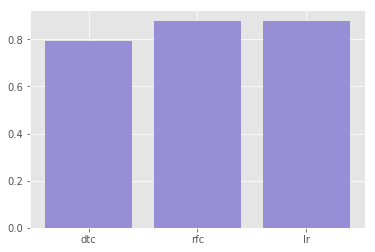

In [55]:
# Визуалищировать эти метрики всех моделей на одном графике (чтоб визуально посмотреть)

## Your Code Here
import matplotlib.pyplot as plt

plt.bar(range(len(precision)), list(precision.values()), align='center')
plt.xticks(range(len(precision)), list(precision.keys()))

plt.bar(range(len(recall)), list(recall.values()), align='center')
plt.xticks(range(len(recall)), list(recall.keys()))

plt.bar(range(len(accuracy)), list(accuracy.values()), align='center')
plt.xticks(range(len(accuracy)), list(accuracy.keys()))

plt.show()

In [29]:
# Потроить roc-кривые всех можелей на одном графике
# Вывести roc_auc каждой моделе

## Your Code Here
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, predict[:,1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

IndexError: too many indices for array

In [ ]:
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold
# Сделать k-fold (10 фолдов) кросс-валидацию каждой модели
# И посчитать средний roc_auc
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

## Your Code Here

In [ ]:
# Взять лучшую модель и сделать predict (с вероятностями (!!!)) для test выборки


## Your Code Here

In [ ]:
# Померить roc_auc на тесте
